**Blackjack Simulator Gotten from https://github.com/engineer-man. This notebook is just used to test out different blackjack strategies and see which is the best one**

In [6]:
import random
import multiprocessing
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
simulations = 1000000
num_decks = 4
shuffle_perc = 75

In [7]:
def simulate(queue, batch_size):
    deck = []

    def new_deck():
        std_deck = [
          # 2  3  4  5  6  7  8  9  10  J   Q   K   A
            2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11,
            2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11,
            2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11,
            2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11,
            ]

        # add more decks
        std_deck = std_deck * num_decks

        random.shuffle(std_deck)

        return std_deck[:]

    def play_hand():
        dealer_cards = []
        player_cards = []

        # deal initial cards
        player_cards.append(deck.pop(0))
        dealer_cards.append(deck.pop(0))
        player_cards.append(deck.pop(0))
        dealer_cards.append(deck.pop(0))

        # deal player to 12 or higher
        while sum(player_cards) < 15:
            player_cards.append(deck.pop(0))

        # deal dealer on soft 17
        while sum(dealer_cards) < 18:
            exit = False
            # check for soft 17
            if sum(dealer_cards) == 17:
                exit = True
                # check for an ace and convert to 1 if found
                for i, card in enumerate(dealer_cards):
                    if card == 11:
                        exit = False
                        dealer_cards[i] = 1
            if exit:
                break
            
            dealer_cards.append(deck.pop(0))

        p_sum = sum(player_cards)
        d_sum = sum(dealer_cards)

        # dealer bust
        if d_sum > 21:
            return 1;
        # dealer tie
        if d_sum == p_sum:
            return 0;
        # dealer win
        if d_sum > p_sum:
            return -1;
        # dealer lose
        if d_sum < p_sum:
            return 1

    # starting deck
    deck = new_deck()

    # play hands
    win = 0
    draw = 0
    lose = 0
    for i in range(0, batch_size):
        # reshuffle cards at shuffle_perc percentage
        if (float(len(deck)) / (52 * num_decks)) * 100 < shuffle_perc:
            deck = new_deck()

        # play hand
        result = play_hand()

        # tally results
        if result == 1:
            win += 1
        if result == 0:
            draw += 1
        if result == -1:
            lose += 1
    plt.plot(win/simulations)
    # add everything to the final results
    queue.put([win, draw, lose])

In [8]:
start_time = time.time()

# simulate
cpus = multiprocessing.cpu_count()
batch_size = int(math.ceil(simulations / float(cpus)))

queue = multiprocessing.Queue()

# create n processes
processes = []

for i in range(0, cpus):
    process = multiprocessing.Process(target=simulate, args=(queue, batch_size))
    processes.append(process)
    process.start()

# wait for everything to finish
for proc in processes:
    proc.join()

finish_time = time.time() - start_time

# get totals
win = 0
draw = 0
lose = 0

for i in range(0, cpus):
    results = queue.get()
    win += results[0]
    draw += results[1]
    lose += results[2]

In [9]:
print ('  cores used: %d' % cpus)
print ('  total simulations: %d' % simulations)
print ('  simulations/s: %d' % (float(simulations) / finish_time))
print ('  execution time: %.2fs' % finish_time)
print ('  win percentage: %.2f%%'  % ((win / float(simulations)) * 100))
print ('  draw percentage: %.2f%%' % ((draw / float(simulations)) * 100))
print ('  lose percentage: %.2f%%' % ((lose / float(simulations)) * 100))

  cores used: 4
  total simulations: 1000000
  simulations/s: 130902
  execution time: 7.64s
  win percentage: 59.40%
  draw percentage: 8.03%
  lose percentage: 32.57%


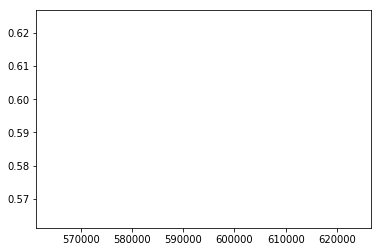

In [18]:
plt.plot(win,win/simulations)